In [154]:
import os
import pydicom
import numpy as np
import datetime
import traceback
import matplotlib.pyplot as plt

In [155]:
file_path = 'dicom_files/Image0023.dcm'

In [156]:
df = pydicom.dcmread(file_path)

In [157]:
df

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Positron Emission Tomography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.28.2.15.30.26408.8305.3.2076.165.1418036529
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.54.2.18.1
(0002, 0013) Implementation Version Name         SH: '18.1.0.0'
-------------------------------------------------
(0004, 1430) Directory Record Type               CS: 'IMAGE'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20141208'
(0008, 0013) Instance Creation Time              TM: '162350'
(0008, 0016) SOP Clas

In [158]:
# Extracting relevant information from dicom file


# Getting patient weight
try:
    weight_grams = float(df.PatientWeight) * 1000
except:
    traceback.print_exc()
    weight_grams = 75000
    estimated = True

try:
    # Get Scan time
    # print(df.AcquisitionTime)

    if '.' not in df.AcquisitionTime:
        scantime = datetime.datetime.strptime(df.AcquisitionTime + '.000000','%H%M%S.%f')
    else:
        scantime = datetime.datetime.strptime(df.AcquisitionTime,'%H%M%S.%f')

    # print(scantime)
    # Start Time for the Radio pharmaceutical Injection

    # if '.' not in df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime:
    #     injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime + '.00000','%H%M%S.%f')
    # else:
    #     injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime,'%H%M%S.%f')

    if '.' not in df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime:
        injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime + '.000000', '%H%M%S.%f')
    else:
        injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime, '%H%M%S.%f')

    # Half Life for Radionuclide # seconds
    half_life = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
    # Total dose injected for Radionuclide
    injected_dose = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)

    # Calculate decay
    decay = np.exp(-np.log(2) * (scantime - injection_time).seconds / half_life)
    # print(decay)
    # Calculate the dose decayed during procedure
    injected_dose_decay = injected_dose * decay  # in Bq
except:
    traceback.print_exc()
    decay = np.exp(-np.log(2) * (1.75 * 3600) / 6588)  # 90 min waiting time, 15 min preparation
    injected_dose_decay = 420000000 * decay  # 420 MBq
    estimated = True

In [159]:
raw = df.pixel_array

# Using corrections using rescale slope and rescale intercept
raw = raw * df.RescaleSlope + df.RescaleIntercept

suv = raw * weight_grams / injected_dose_decay

In [160]:
# Max SUV
np.max(suv)

0.5172150225283814

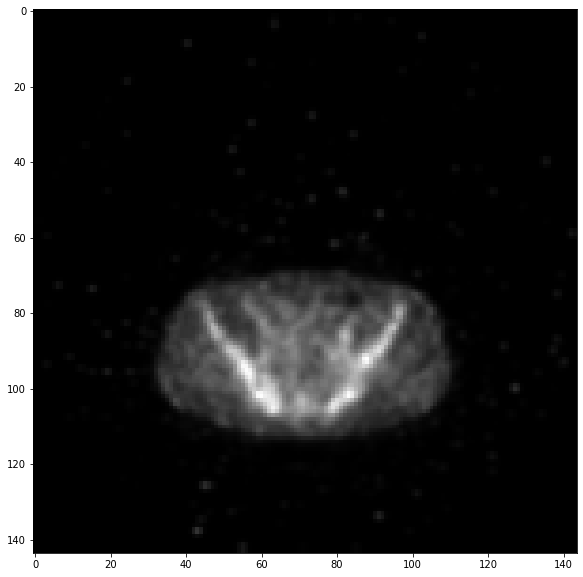

In [167]:
plt.figure(figsize=(10, 10))
plt.imshow(suv, cmap='gray')
plt.show()

In [162]:
def get_suv_max(dicom_file_path):

    df = pydicom.dcmread(dicom_file_path)

    # Extracting relevant information from dicom file


    # Getting patient weight
    try:
        weight_grams = float(df.PatientWeight) * 1000
    except:
        traceback.print_exc()
        weight_grams = 75000
        estimated = True

    try:
        # Get Scan time
        # print(df.AcquisitionTime)

        if '.' not in df.AcquisitionTime:
            scantime = datetime.datetime.strptime(df.AcquisitionTime + '.000000','%H%M%S.%f')
        else:
            scantime = datetime.datetime.strptime(df.AcquisitionTime,'%H%M%S.%f')

        # print(scantime)
        # Start Time for the Radio pharmaceutical Injection

        # if '.' not in df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime:
        #     injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime + '.00000','%H%M%S.%f')
        # else:
        #     injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartDateTime,'%H%M%S.%f')

        if '.' not in df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime:
            injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime + '.000000', '%H%M%S.%f')
        else:
            injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime, '%H%M%S.%f')
        
        # Half Life for Radionuclide # seconds
        half_life = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
        # Total dose injected for Radionuclide
        injected_dose = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)

        # Calculate decay
        decay = np.exp(-np.log(2) * (scantime - injection_time).seconds / half_life)
        # Calculate the dose decayed during procedure
        injected_dose_decay = injected_dose * decay  # in Bq
    except:
        traceback.print_exc()
        decay = np.exp(-np.log(2) * (1.75 * 3600) / 6588)  # 90 min waiting time, 15 min preparation
        injected_dose_decay = 420000000 * decay  # 420 MBq
        estimated = True

    # Calculate SUV # g/ml
    raw = df.pixel_array

    # Using corrections using rescale slope and rescale intercept
    raw = raw * df.RescaleSlope + df.RescaleIntercept

    suv = raw * weight_grams / injected_dose_decay

    return np.max(suv)

In [163]:
suv_arr = []
dicom_files = os.listdir('dicom_files')
for i in range(len(dicom_files)):

    suv_arr.append(get_suv_max(f'dicom_files/{dicom_files[i]}'))

In [164]:
np.max(suv_arr)